In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

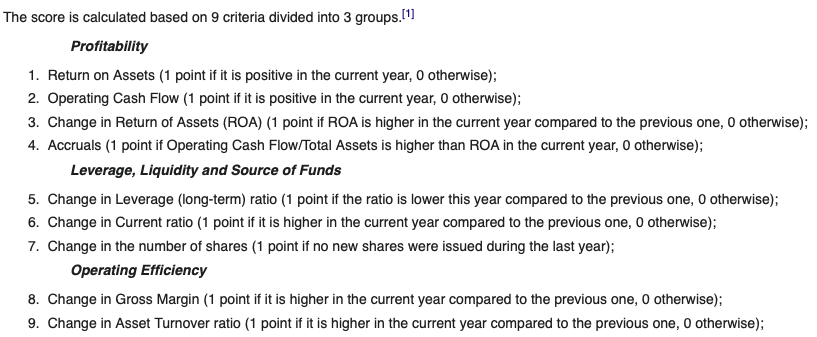

In [2]:
# encodes the attribute values from a set of samples into binary values according to Piotroski's scoring system

def sample_encoder(stocks_df):
    encoded_df = pd.DataFrame(columns=["roa", "ocf", "roa_change", "accruals", "change_leverage",
                                       "change_curr_ratio", "change_shares", "change_gross_margin",
                                       "change_asset_turnover"])

    # for following attributes, encode values > 0 as 1, encode values <= 0 as 0
    for col in ('roa', 'ocf', 'roa_change', 'accruals', 'change_curr_ratio', 'change_gross_margin',
                'change_asset_turnover'):
        values = stocks_df[col]
        encoded_values = (values > 0).astype(int)
        encoded_df[col] = encoded_values

    # for change_leverage, encode values < 0 as 1, encode values >= 0 as 0
    change_leverage_s = stocks_df['change_leverage']
    change_leverage_encoded = (change_leverage_s < 0).astype(int)
    encoded_df['change_leverage'] = change_leverage_encoded

    # for change_shares, encode values <= 0 as 1, encode values > 0 as 0
    change_shares_s = stocks_df['change_shares']
    change_shares_encoded = (change_shares_s <= 0).astype(int)
    encoded_df['change_shares'] = change_shares_encoded

    return encoded_df

In [3]:
# encodes a set of target values into binary values

def target_encoder(price_changes):
    # encode price changes > 0 as 1, encode price changes <= 0 as 0
    encoded_values = (price_changes > 0).astype(int)
    return encoded_values

In [5]:
# load data
sample_data = pd.read_csv('data/stock_sample_data.csv')
judge_data = pd.read_csv('data/stock_judge_data.csv')

In [6]:
sample_data.head()

,roa,ocf,roa_change,accruals,change_leverage,change_curr_ratio,change_shares,change_gross_margin,change_asset_turnover,price_change
0,0.037,928000000.0,-0.047,9.280000e+08,-2.120000e+08,-0.015,-4484973.0,0.008,0.023,0.296364
1,0.084,841000000.0,0.023,8.410000e+08,9.900000e+07,-0.546,1270146.0,0.016,-0.002,-0.034508
2,0.061,615000000.0,0.007,6.150000e+08,2.570000e+08,0.070,-10423009.0,0.018,0.006,0.461156
3,0.054,522000000.0,0.007,5.220000e+08,-1.107000e+09,0.546,-3150912.0,-0.010,-0.106,0.131766
4,0.047,831000000.0,-0.022,8.310000e+08,6.300000e+07,0.121,3513302.0,-0.006,0.008,-0.025072


In [7]:
judge_data.head()

,symbol,roa,ocf,roa_change,accruals,change_leverage,change_curr_ratio,change_shares,change_gross_margin,change_asset_turnover
0,A,0.119,9.410000e+08,0.082,9.410000e+08,608000000,-1.753,-8349639.0,-0.004,0.001
1,AA,-0.074,-1.550000e+08,-0.088,-1.550000e+08,-2000000,-0.039,416818.0,-0.066,-0.127
2,AAC,-0.119,-4.791000e+06,-0.069,-4.791000e+06,117865000,-1.671,783041.0,0.000,-0.176
3,AACG,-0.035,-1.691695e+07,-1.927,-1.691695e+07,25547017,-10.114,15866830.0,2.543,0.025
4,AAL,0.028,3.065000e+09,0.002,3.065000e+09,-585000000,-0.029,-22996804.0,0.004,-0.062


In [8]:
# drop samples that have missing price change values
sample_data.dropna(subset=['price_change'], inplace=True)

In [9]:
# split financial data into sample data (X), and target (y)
X = sample_data.iloc[:, :9]
y = sample_data.iloc[:, -1]

In [10]:
# split samples into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
# get the symbols from judgement data
symbols = judge_data['symbol']

# drop the symbol column from judgement data
judge_data.drop(columns='symbol', inplace=True)

In [12]:
# impute missing testing, training, and judge values with mean values from the training data

columns = ["roa", "ocf", "roa_change", "accruals", "change_leverage",
           "change_curr_ratio", "change_shares", "change_gross_margin",
           "change_asset_turnover"]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=columns)
judge_data_imputed = pd.DataFrame(imputer.transform(judge_data), columns=columns)

In [13]:
# encode each attribute into a binary value

X_train_encoded = sample_encoder(X_train_imputed)
y_train_encoded = target_encoder(y_train)

X_test_encoded = sample_encoder(X_test_imputed)
y_test_encoded = target_encoder(y_test)

judge_data_encoded = sample_encoder(judge_data_imputed)

# normalize the data
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=columns)
X_test_std = pd.DataFrame(scaler.transform(X_test_imputed), columns=columns)
judge_data_std = pd.DataFrame(scaler.transform(judge_data_imputed), columns=columns)

In [14]:
# add the symbol column back to judgement data
judge_data_encoded.insert(0, 'symbol', symbols)
judge_data_std.insert(0, 'symbol', symbols)

In [15]:
# save the preprocessed data to csv

X_train_encoded.to_csv('data/X_train_encoded.csv', index=False)
X_test_encoded.to_csv('data/X_test_encoded.csv', index=False)
judge_data_encoded.to_csv('data/judge_data_encoded.csv', index=False)
np.savetxt('data/y_train_encoded.csv', y_train_encoded, delimiter=',')
np.savetxt('data/y_test_encoded.csv', y_test_encoded, delimiter=',')

# save standardized training and testing data into csv files
X_train_std.to_csv('data/X_train_std.csv', index=False)
X_test_std.to_csv('data/X_test_std.csv', index=False)
judge_data_std.to_csv('data/judge_data_std.csv', index=False)